# **Part 2: Seq2Seq Translation** #

# Step 2.1: Generating the Dataset #

In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Import the french_numbers module from the Files directory
import Files.french_numbers as fn

# Access special tokens from the module
START_VOCAB = fn.START_VOCAB
PAD_ID = fn.PAD_ID
GO_ID = fn.GO_ID
EOS_ID = fn.EOS_ID
UNK_ID = fn.UNK_ID

# Define special tokens for convenience (optional, since they're accessible via fn)
PAD, GO, EOS, UNK = START_VOCAB

# Step 2.2: Building Vocabularies #

In [14]:
def tokenize(sentence, word_level=True):
    if word_level:
        return sentence.split()
    else:
        return [sentence[i:i + 1] for i in range(len(sentence))]

def build_vocabulary(tokenized_sequences):
    rev_vocabulary = START_VOCAB[:]
    unique_tokens = set()
    for tokens in tokenized_sequences:
        unique_tokens.update(tokens)
    rev_vocabulary += sorted(unique_tokens)
    vocabulary = {}
    for i, token in enumerate(rev_vocabulary):
        vocabulary[token] = i
    return vocabulary, rev_vocabulary

# Tokenize sequences
tokenized_fr_train = [tokenize(s, word_level=True) for s in fr_train]
tokenized_num_train = [tokenize(s, word_level=False) for s in num_train]

# Build vocabularies
fr_vocab, rev_fr_vocab = build_vocabulary(tokenized_fr_train)
num_vocab, rev_num_vocab = build_vocabulary(tokenized_num_train)
print("French vocabulary size:", len(fr_vocab))
print("Numeric vocabulary size:", len(num_vocab))
print("Sample French vocab:", rev_fr_vocab[:10])
print("Sample Numeric vocab:", rev_num_vocab[:10])

French vocabulary size: 30
Numeric vocabulary size: 14
Sample French vocab: ['_PAD', '_GO', '_EOS', '_UNK', 'cent', 'cents', 'cinq', 'cinquante', 'deux', 'dix']
Sample Numeric vocab: ['_PAD', '_GO', '_EOS', '_UNK', '0', '1', '2', '3', '4', '5']


# Step 2.3: Preparing Input and Output Sequences for Seq2Seq

In [15]:
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    input_tokens = source_tokens[::-1] if reverse_source else source_tokens
    input_tokens += [GO]
    input_tokens += target_tokens
    output_tokens = target_tokens + [EOS]
    return input_tokens, output_tokens

# Test the function
input_tokens, output_tokens = make_input_output(
    ['quatre', 'cent', 'soixante', 'seize'], ['4', '7', '6'])
print("Input tokens:", input_tokens)
print("Output tokens:", output_tokens)

# Vectorize the corpus
all_tokenized_sequences = tokenized_fr_train + tokenized_num_train
shared_vocab, rev_shared_vocab = build_vocabulary(all_tokenized_sequences)

max_length = 20

def vectorize_corpus(source_sequences, target_sequences, shared_vocab,
                     word_level_source=True, word_level_target=True, max_length=max_length):
    assert len(source_sequences) == len(target_sequences)
    n_sequences = len(source_sequences)
    source_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    source_ids.fill(shared_vocab[PAD])
    target_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    target_ids.fill(shared_vocab[PAD])
    for i, (source_seq, target_seq) in enumerate(zip(source_sequences, target_sequences)):
        source_tokens = tokenize(source_seq, word_level=word_level_source)
        target_tokens = tokenize(target_seq, word_level=word_level_target)
        in_tokens, out_tokens = make_input_output(source_tokens, target_tokens)
        in_token_ids = [shared_vocab.get(t, UNK_ID) for t in in_tokens]
        source_ids[i, -len(in_token_ids):] = in_token_ids
        out_token_ids = [shared_vocab.get(t, UNK_ID) for t in out_tokens]
        target_ids[i, -len(out_token_ids):] = out_token_ids
    return source_ids, target_ids

X_train, Y_train = vectorize_corpus(fr_train, num_train, shared_vocab, word_level_target=False)
X_val, Y_val = vectorize_corpus(fr_val, num_val, shared_vocab, word_level_target=False)
X_test, Y_test = vectorize_corpus(fr_test, num_test, shared_vocab, word_level_target=False)

print("Sample input sequence:", X_train[5])
print("Sample output sequence:", Y_train[5])
print("Corresponding French phrase:", fr_train[5])
print("Corresponding number:", num_train[5])

Input tokens: ['seize', 'soixante', 'cent', 'quatre', '_GO', '4', '7', '6']
Output tokens: ['4', '7', '6', '_EOS']
Sample input sequence: [ 0  0  0  0  0  0  0  0  0  0  0  0 30 33 14 28  1  8 11 10]
Sample output sequence: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8 11 10  2]
Corresponding French phrase: quatre cent soixante seize
Corresponding number: 476


# Step 2.4: Building the Seq2Seq Model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            1280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 64)            18624     
_________________________________________________________________
dense_2 (Dense)              (None, 20, 40)            2600      
Total params: 22,504
Trainable params: 22,504
Non-trainable params: 0
_________________________________________________________________
None
Train on 10000 samples, validate on 5000 samples
Epoch 1/15
 - 3s - loss: 1.0746 - val_loss: 0.6034

Epoch 00001: val_loss improved from inf to 0.60344, saving model to Files/simple_seq2seq_checkpoint.h5
Epoch 2/15
 - 3s - loss: 0.5804 - val_l

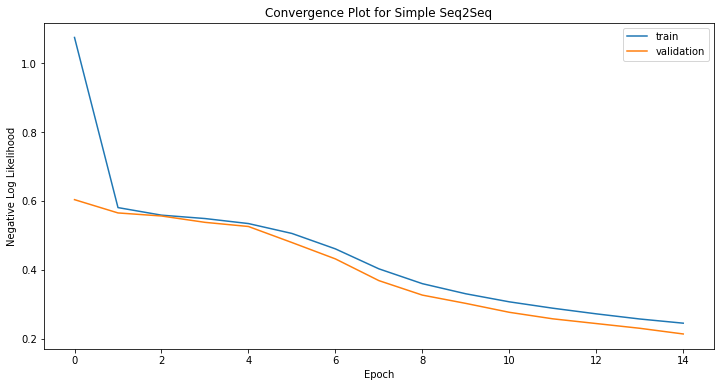

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, GRU, Dense


# Build the Seq2Seq model
vocab_size = len(shared_vocab)
embedding_dim = 32
gru_units = 64

simple_seq2seq = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Dropout(0.2),
    GRU(gru_units, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

simple_seq2seq.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
print(simple_seq2seq.summary())

# Train the model with a checkpoint
from keras.callbacks import ModelCheckpoint

best_model_fname = "Files/simple_seq2seq_checkpoint.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss', save_best_only=True, verbose=1)

history = simple_seq2seq.fit(X_train, np.expand_dims(Y_train, -1),
                             validation_data=(X_val, np.expand_dims(Y_val, -1)),
                             epochs=15, batch_size=32, verbose=2, callbacks=[best_model_cb])

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('Epoch')
plt.title('Convergence Plot for Simple Seq2Seq')
plt.legend()
plt.show()

# Load the best model
from keras.models import load_model
simple_seq2seq = load_model(best_model_fname, compile=False)

In [ ]:
# AttributeError: 'str' object has no attribute 'decode'
# Solution:

pip install h5py==2.10.0

# Step 2.5: Decoding and Evaluating the Seq2Seq Model

In [29]:
def greedy_translate(model, source_sequence, shared_vocab, rev_shared_vocab,
                     word_level_source=True, word_level_target=True):
    source_tokens = tokenize(source_sequence, word_level=word_level_source)
    input_ids = [shared_vocab.get(t, UNK_ID) for t in source_tokens[::-1]]
    input_ids += [shared_vocab[GO]]
    input_array = np.empty(shape=(1, model.input_shape[1]), dtype=np.int32)
    decoded_tokens = []
    while len(input_ids) <= max_length:
        input_array.fill(shared_vocab[PAD])
        input_array[0, -len(input_ids):] = input_ids
        next_token_id = model.predict(input_array, verbose=0)[0, -1].argmax()
        if next_token_id == shared_vocab[EOS]:
            break
        decoded_tokens.append(rev_shared_vocab[next_token_id])
        input_ids.append(next_token_id)
    separator = " " if word_level_target else ""
    return separator.join(decoded_tokens)

# Test some translations
phrases = [
    "un", "deux", "trois", "onze", "quinze", "cent trente deux",
    "cent mille douze", "sept mille huit cent cinquante neuf",
    "vingt et un", "vingt quatre", "quatre vingts",
    "quatre vingt onze mille", "quatre vingt onze mille deux cent deux"
]
for phrase in phrases:
    translation = greedy_translate(simple_seq2seq, phrase, shared_vocab, rev_shared_vocab, word_level_target=False)
    print(phrase.ljust(40), translation)

print("\n___DECODING___\n")

# Evaluate phrase-level accuracy
def phrase_accuracy(model, num_sequences, fr_sequences, n_samples=300, decoder_func=greedy_translate):
    correct = []
    n_samples = min(n_samples, len(num_sequences))
    for i, (num_seq, fr_seq) in enumerate(zip(num_sequences[:n_samples], fr_sequences[:n_samples])):
        if i % 100 == 0:
            print(f"Decoding {i}/{n_samples}")
        predicted_seq = decoder_func(simple_seq2seq, fr_seq, shared_vocab, rev_shared_vocab, word_level_target=False)
        correct.append(num_seq == predicted_seq)
    return np.mean(correct)

print(f"Phrase-level test accuracy: {phrase_accuracy(simple_seq2seq, num_test, fr_test)}\n")
print(f"Phrase-level train accuracy: {phrase_accuracy(simple_seq2seq, num_train, fr_train)}\n")

un                                       110
deux                                     200
trois                                    300
onze                                     1100
quinze                                   51
cent trente deux                         132
cent mille douze                         1002
sept mille huit cent cinquante neuf      78004
vingt et un                              20
vingt quatre                             24
quatre vingts                            80
quatre vingt onze mille                  80001
quatre vingt onze mille deux cent deux   4262

___DECODING___

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level test accuracy: 0.043333333333333335

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level train accuracy: 0.04666666666666667

